## Applying NLP to identify disaster tweets.

The aim of this notebook is to explore NLP via the analysis of a dataset containing tweets. Some of these tweets mention disasters, some do not. I aim to clean the data, investigate the relationship between various features and target values (note: this is a classification problem), before cleaning and preprocessing the text using spaCy. After this process is complete, I will apply a variety of models and use the most accurate one for my predictions.

## Note

This project is quite messy and may contain bits of code that currently have no apparent use. There is a decent bit of test code towards the end in particular. 

It is my intention for this project to be somewhat modular. As I learn about new libraries and techniques, I may apply them in this project if there is a chance they may help give more accurate predictions. In particular, I am keen to apply some of the tools contained in Tensorflow once I have studied it to a degree I deem sufficient.

## Current state:

I have been in the process of correcting the very end of this project (the application of the chosen model to test data). Recently, I have been working on another project but will likely return to this project once I am done.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing 
# Feature extraction allows extraction of features in a format supported my ML algs from datasets containing text and image.
# Linear_model: linear regression
# Model_selection: chooses estimators and parameters.
# preprocessing: functions and transformer classes that change raw feature vectors into a more preferable form for estimators that are downstream.
import re
from tqdm import tqdm 

In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv") 

### A quick look at our data


In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Cleaning the Data


In [5]:
# Find the number of missing data points per column.
missing_values = train_df.isnull().sum()
# Show the distribution of missing data points across the columns of the data set.
missing_values 

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
train_df.fillna('0', inplace = True)

In [7]:
train_df

,id,keyword,location,text,target
0,1,0,0,Our Deeds are the Reason of this #earthquake M...,1
1,4,0,0,Forest fire near La Ronge Sask. Canada,1
2,5,0,0,All residents asked to 'shelter in place' are ...,1
3,6,0,0,"13,000 people receive #wildfires evacuation or...",1
4,7,0,0,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,0,0,Two giant cranes holding a bridge collapse int...,1
7609,10870,0,0,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,0,0,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,0,0,Police investigating after an e-bike collided ...,1


In [8]:
texts = list(train_df.text)
labels = list(train_df.target)

In [9]:
# This script will remove unwanted characters (such as @ and #). A more advanced version of this has been implemented further down the line.

def preprocess_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r"http\S+", "", tweet)
    
    # Remove mentions
    tweet = re.sub(r"@\w+", "", tweet)
    
    # Remove hashtags
    tweet = re.sub(r"#\w+", "", tweet)
    
    return tweet


In [10]:
for i in tqdm(range(len(texts))):
    texts[i] = preprocess_tweet(texts[i].strip())

100%|██████████| 7613/7613 [00:00<00:00, 113088.17it/s]


### Feature Engineering

Here I will explore the dependance of the target value on various features such as keyword and location. 

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
keyword = train_df.groupby("keyword")["target"].count() # groups rows by keyword and assigns a count for each one.

keyword_df = pd.DataFrame(data={"keyword":keyword.index, "count":keyword.values}).sort_values(by=["count"],ascending=False)
keyword_df

,keyword,count
0,0,61
105,fatalities,45
64,deluge,42
9,armageddon,42
178,sinking,41
...,...,...
116,forest%20fire,19
95,epicentre,12
195,threat,11
135,inundation,10


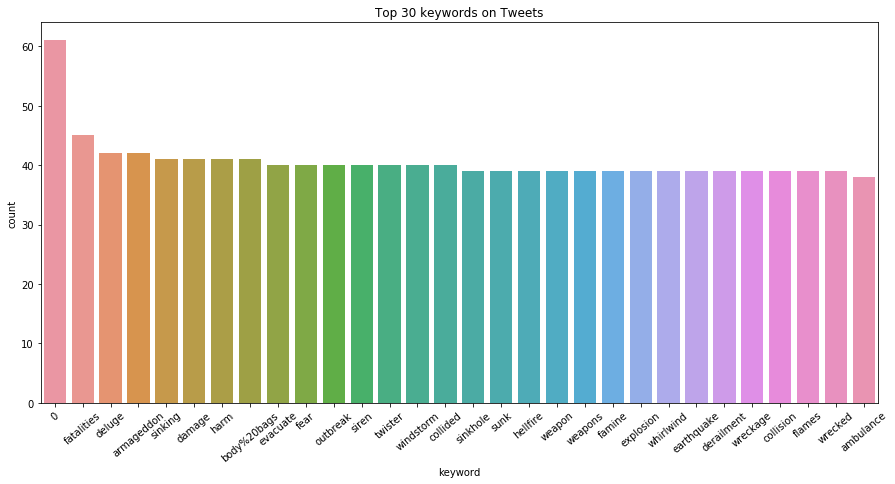

In [13]:
plt.figure(figsize=(15,7))
sns.barplot(data=keyword_df.head(30), x = 'keyword',y = 'count')
plt.xticks(rotation = 40)
plt.title('Top 30 keywords on Tweets');

As can be seen, the keywords that you would expect from a tweet heralding a disaster such as 'damage' and 'harm' are prolific. The next feature to be examined will be tweet length.

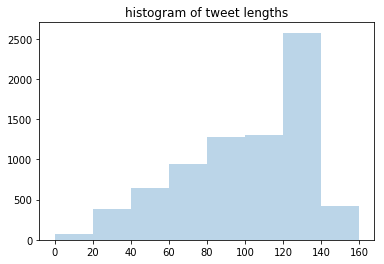

In [14]:
def plot_tweet_lengths(df):
    # Find lengths.
    ldf = pd.DataFrame(columns = ['lengths'])
    i = 0
    for text in df['text']:
        ldf.loc[i, 'lengths'] = len(text)
        i = i + 1
    # plot histogram
    increments = range(0, 180, 20)
    plt.hist(ldf['lengths'],bins = increments, alpha = 0.3)
    plt.title('histogram of tweet lengths')

plot_tweet_lengths(train_df)

In [15]:
def sentence_lengths(df):
    ldf = pd.DataFrame(columns = ['lengths'])
    i = 0
    for text in df['text']:
        ldf.loc[i, 'lengths'] = len(text)
        i = i + 1
    return ldf


new_ldf = sentence_lengths(train_df)

merged_df = pd.concat([new_ldf, train_df["target"]], axis=1) # Set up a DataFrame with columns for lengths and the corresponding binary target value.
merged_df

,lengths,target
0,69.0,1
1,38.0,1
2,133.0,1
3,65.0,1
4,88.0,1
...,...,...
7608,83.0,1
7609,125.0,1
7610,65.0,1
7611,137.0,1


Text(0.5, 1.0, 'The dependance of target value on tweet length')

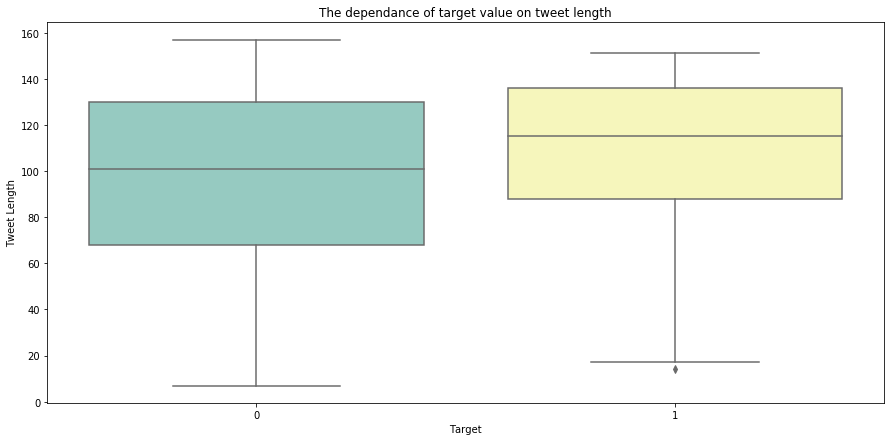

In [16]:
plt.figure(figsize=(15,7))
sns.boxplot(x = merged_df['target'], y = merged_df['lengths'], palette = 'Set3')
plt.xlabel('Target')
plt.ylabel('Tweet Length')
plt.title('The dependance of target value on tweet length')

It can be seen that disaster tweets tend to have a greater length than non-disaster tweets, although there is a greater range in the lengths of normal tweets.

### Preprocessing Pipelines


Now, the text will be processed in order to allow the training of models based on features. I will use **spaCy** for this purpose. 

In [17]:
import spacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

nlp = spacy.load('en_core_web_sm')

text1 = nlp(texts[1])

text1

Forest fire near La Ronge Sask. Canada

In [18]:
disaster_text = []  

for i in tqdm(range(0,7613)):
    
    # Test whether a given post is a disaster post (target = 1). Then tokenize and append if applicable.
    
    if train_df.target[i] == 1:
    
        disaster_text.append(nlp(texts[i]))
disaster_text[1]

100%|██████████| 7613/7613 [00:42<00:00, 180.48it/s]


Forest fire near La Ronge Sask. Canada

In [71]:
def preprocessor(text):
    #clean_text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags = re.MULTILINE)
    #clean_text = re.sub(r'[^\w\s]', '', clean_text)
    
    tokens = nlp(text)
    
    clear_token_list = [token.text for token in tokens if not token.is_punct]
    clear_token_list = [token for token in clear_token_list if not re.match(r'[^\w\s]', token)]
    clear_token_list = [token for token in clear_token_list if not re.match(r"http\S+|www\S+|https\S+", token, flags=re.MULTILINE)]
    
    #nopunct_token_list = [token.text for token in tokens if not token.is_punct]
    return clear_token_list

#train_df['text'] = train_df['text'].apply(preprocessor)

In [ ]:
train_df['text'][100]

In [19]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(train_df['text'])

In [20]:
print(tfidf_matrix)

  (0, 1851)	0.20827049400579561
  (0, 19774)	0.24477443310741195
  (0, 7661)	0.41872819867651895
  (0, 1852)	0.3616934826352278
  (0, 12141)	0.2592123351950127
  (0, 6379)	0.2904421828375658
  (0, 18777)	0.1800147670172314
  (0, 13681)	0.11990034967586292
  (0, 15678)	0.3265463550381381
  (0, 18669)	0.10169057350001784
  (0, 2192)	0.18937339953178942
  (0, 5490)	0.41872819867651895
  (0, 14003)	0.25309130456401624
  (1, 3843)	0.385143605810349
  (1, 16611)	0.48782712843724685
  (1, 16266)	0.48782712843724685
  (1, 11091)	0.35894718133854775
  (1, 13122)	0.31294120486788174
  (1, 7439)	0.2365324860692921
  (1, 7652)	0.30494408465089573
  (2, 7014)	0.21673027088707333
  (2, 13936)	0.22543202425089304
  (2, 13919)	0.14033250463283808
  (2, 6909)	0.18226487642545727
  (2, 13987)	0.1890144807081105
  :	:
  (7611, 9967)	0.23002920725460307
  (7611, 1670)	0.14089321956887677
  (7611, 16895)	0.234316081644427
  (7611, 11518)	0.19409754291276166
  (7611, 16086)	0.2615176214985051
  (7611, 11421

## Training Models

Here I will run the training data through a selection of models in order to see which gives the most accurate results.

In [21]:
categorical_features = ["text"]

preprocessor = ColumnTransformer(
    transformers=[
      ('tfidf', vectorizer, 'text'),  
    ]
)

In [22]:
x = train_df.iloc[:, :-1]
y = train_df.iloc[:,-1]
x.drop("id", axis=1, inplace=True)

In [23]:
x

,keyword,location,text
0,0,0,Our Deeds are the Reason of this #earthquake M...
1,0,0,Forest fire near La Ronge Sask. Canada
2,0,0,All residents asked to 'shelter in place' are ...
3,0,0,"13,000 people receive #wildfires evacuation or..."
4,0,0,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...
7608,0,0,Two giant cranes holding a bridge collapse int...
7609,0,0,@aria_ahrary @TheTawniest The out of control w...
7610,0,0,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,0,0,Police investigating after an e-bike collided ...


In [24]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()

clf_lg = Pipeline(
    steps = [("vectorizer", preprocessor), ("classifier", lg)]
)

clf_lg.fit(x, y)
print("model_score: %.3f" %clf_lg.score(x, y))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


model_score: 0.884


In [25]:
train_df.iloc[:, :-1]

,id,keyword,location,text
0,1,0,0,Our Deeds are the Reason of this #earthquake M...
1,4,0,0,Forest fire near La Ronge Sask. Canada
2,5,0,0,All residents asked to 'shelter in place' are ...
3,6,0,0,"13,000 people receive #wildfires evacuation or..."
4,7,0,0,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...
7608,10869,0,0,Two giant cranes holding a bridge collapse int...
7609,10870,0,0,@aria_ahrary @TheTawniest The out of control w...
7610,10871,0,0,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,10872,0,0,Police investigating after an e-bike collided ...


In [26]:
from sklearn.svm import SVC

svc = SVC() 

clf_svc = Pipeline(
    steps = [("preprocessor", preprocessor), ("classifier", svc)]
)

clf_svc.fit(x, y)
print("model_score: %.3f" %clf_svc.score(x, y))

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


model_score: 0.570


In [27]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

clf_rfc = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", rfc)]
)

clf_rfc.fit(x, y)
print('model score: %.3f' % clf_rfc.score(x, y))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model score: 0.976


In [28]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

clf_gbc = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", gbc)]
)

clf_gbc.fit(x, y)
print("model score: %.3f" % clf_gbc.score(x, y))

model score: 0.781


In [29]:
import xgboost

xgb = xgboost.XGBClassifier()

clf_xgb = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", xgb)]
)

clf_xgb.fit(x, y)
print("model score: %.3f" % clf_xgb.score(x, y))

model score: 0.770


In [30]:
from sklearn.ensemble import BaggingClassifier

bgc = BaggingClassifier()

clf_bgc = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", bgc)]
)

clf_bgc.fit(x, y)
print('model score: %.3f' % clf_bgc.score(x, y))

model score: 0.977


In [31]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10),
                    max_iter=1000)

clf_mlp = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", mlp)]
)

clf_mlp.fit(x, y)
print("model score: %.3f" % clf_mlp.score(x, y))

model score: 0.996


We can see that, with the given parameters, MLPclassifier gives the most accurate results- with an accuracy of around 0.996 for the training data.

## Predictions and my submission.

In [ ]:
clf.fit(train_vectors, train_df["target"]) 

In [51]:
test_df['text'] = test_df['text'].apply(preprocessor)

In [64]:
#test_df.head()
#test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv") 
#x.head()
test_df = test_df.drop("id", axis=1, inplace=True)

In [78]:
y_predicted = clf_mlp.predict(test_df['text'])
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [ ]:
sample_submission["target"] = clf.predict(test_vectors)

In [ ]:
sample_submission.head()

In [ ]:
sample_submission.to_csv("submission.csv", index=False)